# Libaries + intit

In [ ]:
!pip install transformers
# !pip install torchviz

     |████████████████████████████████| 4.2 MB 31.8 MB/s 
     |████████████████████████████████| 6.6 MB 67.3 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Misc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from google.colab import drive 
import random
from tqdm.auto import tqdm
from collections import defaultdict

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#deep learning / pytorch
import torch 
from torch import nn, optim
from transformers import AutoTokenizer, AutoModelForPreTraining, AdamW, get_scheduler, get_linear_schedule_with_warmup
import torch.nn.functional as F
from torch.utils.data import DataLoader
# from torchviz import make_dot

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Data cleaning + Data Split

In [ ]:
#get data
drive_path = 'gdrive/My Drive/DTU/Special kursus/data_small/'
df = pd.read_csv(drive_path+'hadtale_kurateret.csv',sep='\t')

# Seperate comments from 'core'  text.
df['comment_text']=df['comment_text'].apply(lambda x: x.split('\n'))
df['comment_text_core']=df['comment_text'].apply(lambda x: x[0])
df['comment_text_comments']=df['comment_text'].apply(lambda x: x[1:])

def remove_empty_strings(a_list):
  without_empty_strings = []
  for string in a_list:
      if (string != ""):
          without_empty_strings.append(string)
  return without_empty_strings

df['comment_text_comments']=df['comment_text_comments'].apply(lambda x: remove_empty_strings(x))
df['comment_text_N_comments']=df['comment_text_comments'].apply(lambda x: len(x))

# one-hot encoding
df=df.join(pd.get_dummies(df['class_text']))

#split
df_train,df_test=train_test_split(df,test_size=0.4,random_state=1)
df_test,df_eval=train_test_split(df_test,test_size=0.25,random_state=1)

print('Train size: ' + str(len(df_train))+' - '+str(len(df_train)/len(df)*100)+' %')
print('Test size: ' + str(len(df_test))+' - '+str(len(df_test)/len(df)*100)+' %')
print('Validation size: ' + str(len(df_eval))+' - '+str(len(df_eval)/len(df)*100)+' %')

df_train.head()

Train size: 1200 - 60.0 %
Test size: 600 - 30.0 %
Validation size: 200 - 10.0 %


,class,class_text,comment_text,comment_text_core,comment_text_comments,comment_text_N_comments,andet,hadtale
1616,2,hadtale,[Føj.. Jeg bliver dårlig over at læse det. Han...,Føj.. Jeg bliver dårlig over at læse det. Han ...,[],0,0,1
1695,2,hadtale,[Hvorfor bruge tid på at dele hans historie. F...,Hvorfor bruge tid på at dele hans historie. Fu...,[],0,0,1
35,0,andet,[Venstre regeringen gav heller ikke noget til ...,Venstre regeringen gav heller ikke noget til A...,[],0,1,0
941,0,andet,[Du ser også gammel ud ift mig 😂😂🤪🥳😘],Du ser også gammel ud ift mig 😂😂🤪🥳😘,[],0,1,0
1386,2,hadtale,[Tony robbins er også en klam børnepiller. Men...,Tony robbins er også en klam børnepiller. Men ...,[],0,0,1


# Data Prep - Dataloader + Tokenizer

In [ ]:
electra_huggingface='Maltehb/aelaectra-danish-electra-small-cased'
tokenizer = AutoTokenizer.from_pretrained(electra_huggingface)

Downloading:   0%|          | 0.00/111 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/784 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
class Dataset():
  def __init__(self, texts, targets, tokenizer, max_len):
    self.text = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)}

In [ ]:
def create_dataloader(df, tokenizer, max_len, batch_size):
  ds = Dataset(
    texts=df["comment_text_core"].to_numpy(),
    targets=df['hadtale'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

  return DataLoader(ds,batch_size=batch_size,num_workers=2)


train_dataloader = create_dataloader(df_train, tokenizer, 200, 8)
test_dataloader = create_dataloader(df_test, tokenizer, 200, 8)
eval_dataloader = create_dataloader(df_eval, tokenizer, 200, 8)

# Model

In [ ]:
#init
from transformers import ElectraModel
electraModel = ElectraModel.from_pretrained(electra_huggingface)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Downloading:   0%|          | 0.00/55.3M [00:00<?, ?B/s]

Some weights of the model checkpoint at Maltehb/aelaectra-danish-electra-small-cased were not used when initializing ElectraModel: ['generator.encoder.layer.6.output.dense.bias', 'generator.encoder.layer.0.attention.output.LayerNorm.bias', 'generator.encoder.layer.2.attention.self.value.bias', 'generator.encoder.layer.10.attention.self.query.weight', 'generator.encoder.layer.10.attention.output.dense.bias', 'generator.encoder.layer.0.output.dense.weight', 'generator.encoder.layer.0.output.LayerNorm.bias', 'generator.encoder.layer.5.attention.self.key.weight', 'generator.encoder.layer.4.attention.self.query.bias', 'generator.encoder.layer.9.attention.self.key.bias', 'generator.encoder.layer.7.attention.output.dense.weight', 'generator.encoder.layer.7.attention.output.LayerNorm.bias', 'generator.encoder.layer.7.output.dense.weight', 'generator.encoder.layer.5.attention.self.query.bias', 'generator.encoder.layer.1.attention.output.dense.weight', 'generator.encoder.layer.3.attention.output

cuda:0


In [ ]:
class ElectraClassifier(nn.Module):
    def __init__(self,num_labels=2):
        super(ElectraClassifier, self).__init__()
        self.num_labels = num_labels
        self.electra = ElectraModel.from_pretrained(electra_huggingface)
        self.dense1 = nn.Linear(self.electra.config.hidden_size, self.electra.config.hidden_size)
        self.dropout1 = nn.Dropout(self.electra.config.hidden_dropout_prob)
        self.dropout2 = nn.Dropout(self.electra.config.hidden_dropout_prob)
        self.out_proj = nn.Linear(self.electra.config.hidden_size, self.num_labels)

    def classifier(self,sequence_output):
        x = sequence_output[:, 0, :]
        # x = self.dropout1(x)
        x = F.gelu(self.dense1(x))
        x = self.dropout2(x)
        logits = self.out_proj(x)
        sm = nn.Softmax(dim=1)
        return sm(logits)

    def forward(self, input_ids=None,attention_mask=None):
        discriminator_hidden_states = self.electra(input_ids=input_ids,attention_mask=attention_mask)
        sequence_output = discriminator_hidden_states[0]
        logits = self.classifier(sequence_output)
        return logits

In [ ]:
model=ElectraClassifier()
model = model.to(device)

Some weights of the model checkpoint at Maltehb/aelaectra-danish-electra-small-cased were not used when initializing ElectraModel: ['generator.encoder.layer.6.output.dense.bias', 'generator.encoder.layer.0.attention.output.LayerNorm.bias', 'generator.encoder.layer.2.attention.self.value.bias', 'generator.encoder.layer.10.attention.self.query.weight', 'generator.encoder.layer.10.attention.output.dense.bias', 'generator.encoder.layer.0.output.dense.weight', 'generator.encoder.layer.0.output.LayerNorm.bias', 'generator.encoder.layer.5.attention.self.key.weight', 'generator.encoder.layer.4.attention.self.query.bias', 'generator.encoder.layer.9.attention.self.key.bias', 'generator.encoder.layer.7.attention.output.dense.weight', 'generator.encoder.layer.7.attention.output.LayerNorm.bias', 'generator.encoder.layer.7.output.dense.weight', 'generator.encoder.layer.5.attention.self.query.bias', 'generator.encoder.layer.1.attention.output.dense.weight', 'generator.encoder.layer.3.attention.output

In [ ]:
EPOCHS = 50
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False,no_deprecation_warning=True)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(input_ids=input_ids,attention_mask=attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in tqdm(range(EPOCHS)):

  train_acc, train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device, scheduler,len(df_train))
  val_acc, val_loss = eval_model(model, eval_dataloader, loss_fn, device, len(df_eval))

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

  0%|          | 0/50 [00:00<?, ?it/s]

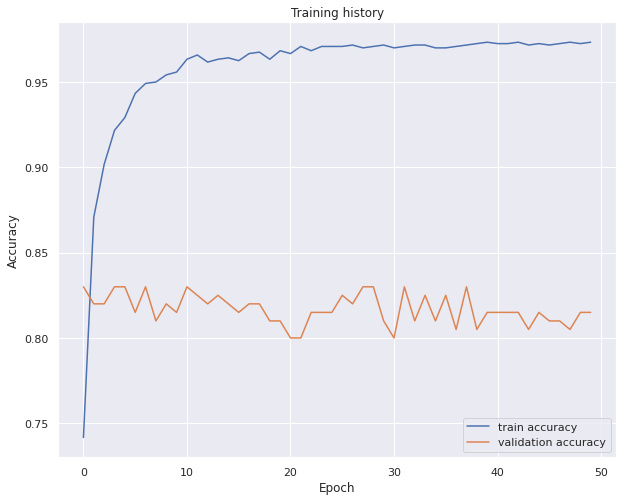

In [ ]:
train_acc = []
for i in history['train_acc']:
  train_acc.append(i.cpu().detach().numpy())

val_acc = []
for i in history['val_acc']:
  val_acc.append(i.cpu().detach().numpy())

plt.figure(figsize=(10,8))
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model eval

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_dataloader)
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.8869    0.8019    0.8423       313
           1     0.8044    0.8885    0.8444       287

    accuracy                         0.8433       600
   macro avg     0.8457    0.8452    0.8433       600
weighted avg     0.8475    0.8433    0.8433       600



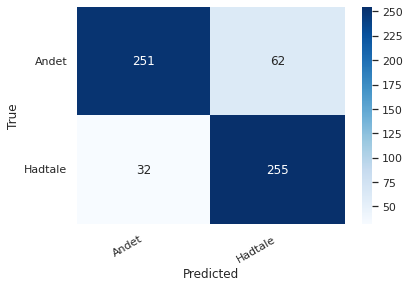

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['Andet','Hadtale'], columns=['Andet','Hadtale'])
show_confusion_matrix(df_cm)